In [55]:
import string
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from collections import Counter
import pandas as pd
import torch
from transformers import AutoModel, AutoTokenizer
import numpy as np
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import re
import umap
from sklearn.manifold import TSNE
plt.rcParams['figure.dpi'] = 300

#### Preprocessing

In [56]:
def contextual_preprocess(tweet):
    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', '', tweet)
    tweet = re.sub(r'[\u064B-\u0652]', '', tweet)
    tweet = re.sub(r'[^\u0621-\u064A\u0660-\u0669 ]+', ' ', tweet)
    tweet = re.sub(r'\s+', ' ', tweet)
    return tweet

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
def contextual_embeddings(tweets):
  base_model_name = 'moha/arabert_c19'
  tokenizer = AutoTokenizer.from_pretrained(base_model_name)
  base_model = AutoModel.from_pretrained(base_model_name).to(device)
  base_model.eval()
  for param in base_model.parameters():
    param.requires_grad = False

  tokens = [tokenizer(tweet,
                padding='max_length',
                max_length=512,
                truncation=True,
                return_tensors="pt") for tweet in tweets
  ]

  embeddings = [(base_model(input_ids=token['input_ids'].to(device),
                            attention_mask=token['attention_mask'].to(device),
                            return_dict=False)[1]).detach().cpu()
                for token in tqdm(tokens)]

  return embeddings

#### Apply the Contextual Embeddings

In [59]:
DIR = lambda x : f'../../Dataset/SavedFeatures/CONTEXT/{x}.npy'
D_DIR = lambda x : f'../../Dataset/{x}.npy'

Preprocessing = {"approach": "contextual"}
Features = {"method": "contextual"}

y1 = np.load(D_DIR('y1'), allow_pickle=True)
y2 = np.load(D_DIR('y2'), allow_pickle=True)
Y1 = np.load(D_DIR('Y1_test'), allow_pickle=True)
Y2 = np.load(D_DIR('Y2_test'), allow_pickle=True)

saved = True
if saved:
    x = np.load(DIR('x'), allow_pickle=True)
    X = np.load(DIR('X_test'), allow_pickle=True)
    
else:
   x = pd.read_csv('../../Dataset/train.csv')
   X = pd.read_csv('../../Dataset/dev.csv')
   x = [contextual_preprocess(tweet) for tweet in x['text']]
   X = [contextual_preprocess(tweet) for tweet in X['text']]
   x = contextual_embeddings(x)
   X = contextual_embeddings(X)


#### Visualization

/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


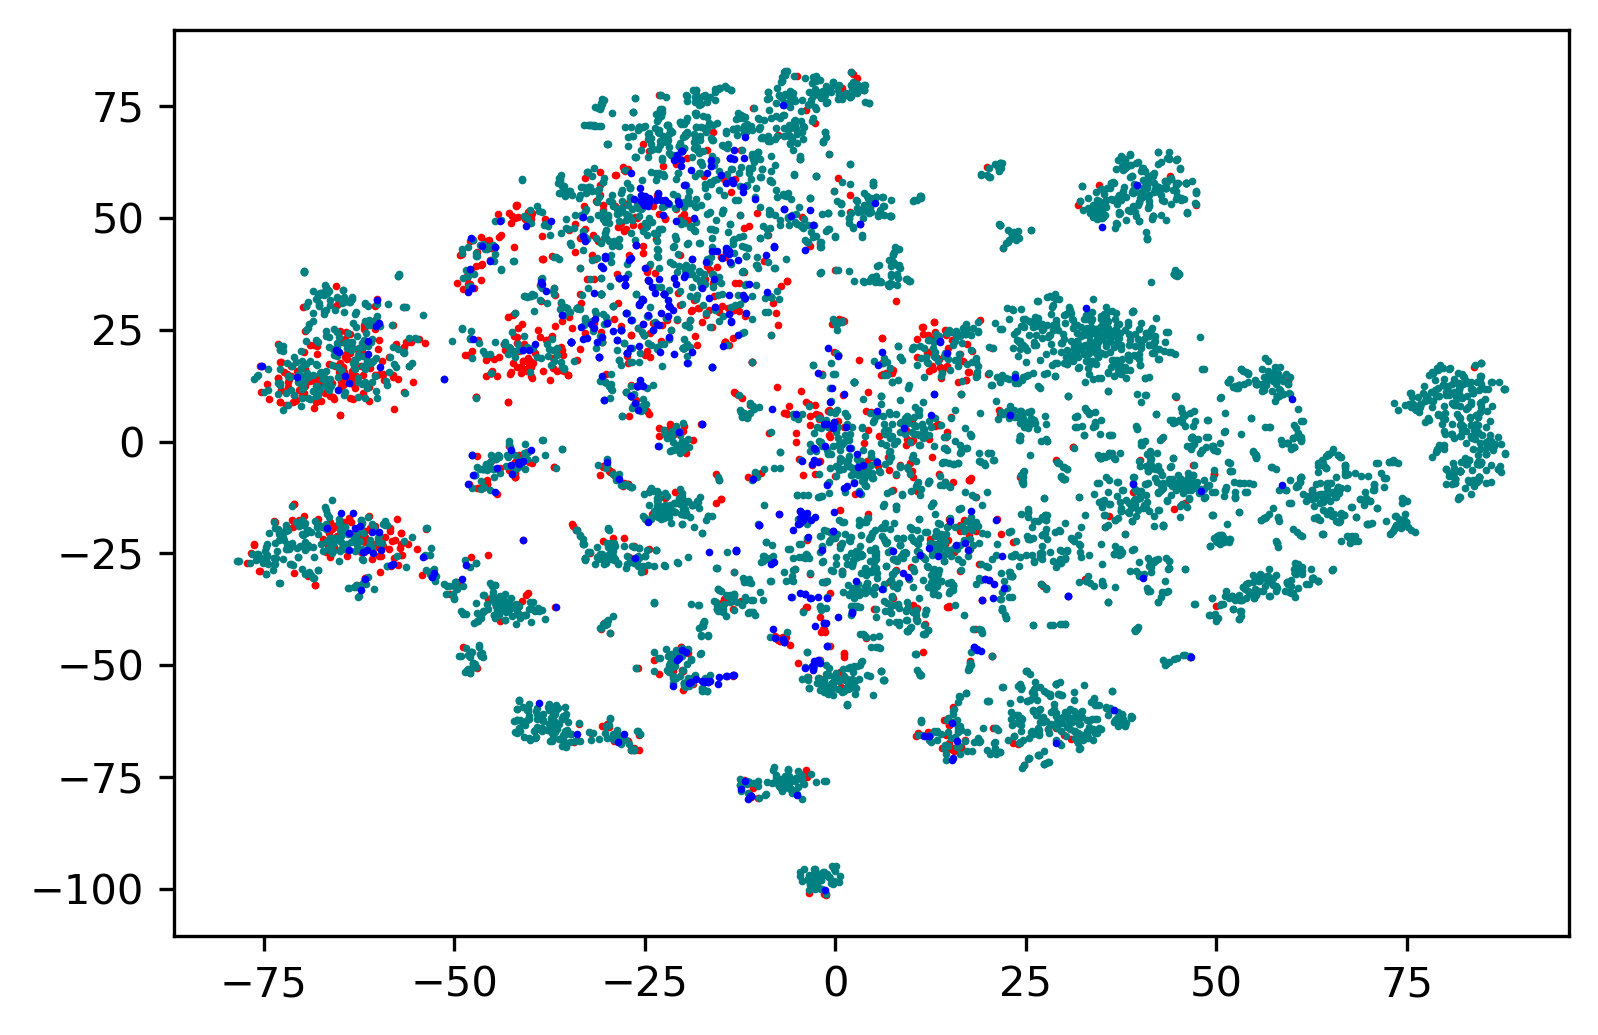

In [60]:
if not saved:
   tsne = TSNE(n_components=2)
   x_t = tsne.fit_transform(x[:,0,:])
   x1, x2, x3 = x_t[y1==0], x_t[y1==1], x_t[y1==2]
   plt.scatter(x1[:,0], x1[:,1], c='red', s=0.7)
   plt.scatter(x2[:,0], x2[:,1], c='teal', s=0.7)
   plt.scatter(x3[:,0], x3[:,1], c='blue', s=0.7)
   plt.show()